In [23]:
get_ipython().run_line_magic('matplotlib', 'widget')

In [21]:
pip install rocketcea

Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [25]:
pip install jsonpickle

Note: you may need to restart the kernel to use updated packages.


In [26]:
pip install windrose

Note: you may need to restart the kernel to use updated packages.


In [27]:
pip install simplekml

Note: you may need to restart the kernel to use updated packages.


In [28]:
pip install --upgrade cffi

Note: you may need to restart the kernel to use updated packages.


In [29]:
pip install --upgrade rocketpy

Note: you may need to restart the kernel to use updated packages.


In [30]:
pip install timezonefinder

Note: you may need to restart the kernel to use updated packages.


In [31]:
from datetime import datetime
from time import process_time, perf_counter, time
import glob

from rocketpy import Environment, Rocket, LiquidMotor, Flight, Function
from rocketpy.motors import Tank, TankGeometry, Fluid

import numpy as np
from numpy.random import normal, uniform, choice
from IPython.display import display

Exception: Version mismatch: this is the 'cffi' package version 1.14.6, located in '/opt/conda/lib/python3.9/site-packages/cffi/api.py'.  When we import the top-level '_cffi_backend' extension module, we get version 1.16.0, located in '/opt/conda/lib/python3.9/site-packages/_cffi_backend.cpython-39-x86_64-linux-gnu.so'.  The two versions should be equal; check your installation.

In [32]:
%config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams["figure.figsize"] = [8, 5]
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["figure.titlesize"] = 14

In [33]:
import rocketcea
import os
import numpy as np
import scipy
from scipy.optimize import minimize
import tkinter as tk
import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.matplotlib_fname())
from rocketcea.cea_obj import CEA_Obj
import pandas as pd
import math
import datetime

/opt/conda/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc


In [14]:
from rocketpy import Environment, Rocket, LiquidMotor, Flight

In [15]:
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [16]:
%matplotlib widget

In [17]:
env = Environment(
    latitude=32.9901, 
    longitude=-106.9751, 
    elevation=1400.556
)

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

env.set_date(
  (tomorrow.year, tomorrow.month, tomorrow.day, 12), timezone="America/Denver") 
# Tomorrow's date in year, month, day, hour UTC format

env.set_atmospheric_model(type='Forecast', file='GFS')

#Env.setAtmosphericModel(type="CustomAtmosphere", wind_v=-5)

oc_open: server error retrieving url: code=0 message="/gfs_0p25/gfs20231010/gfs_0p25_00z is not an available dataset"


Gravity Details

Acceleration of Gravity at Lauch Site: 9.791112956972544 m/s²


Launch Site Details

Launch Date: 2023-10-10 18:00:00 UTC | 2023-10-10 12:00:00 America/Denver
Launch Site Latitude: 32.99010°
Launch Site Longitude: -106.97510°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 315458.79 W    3651921.75 N
Launch Site UTM zone: 13S
Launch Site Surface Elevation: 1471.3 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 78.668 km
Forecast Time Period: From  2023-10-09 18:00:00  to  2023-10-25 18:00:00  UTC
Forecast Hour Interval: 3  hrs
Forecast Latitude Range: From  -90.0 ° To  90.0 °
Forecast Longitude Range: From  0.0 ° To  359.75 °


Surface Atmospheric Conditions

Surface Wind Speed: 2.06 m/s
Surface Wind Direction: 281.45°
Surface Wind Heading: 101.45°
Surface Pressure: 848.35 hPa
Surface Temperature: 296.24 K
Surface Air Density: 0.998 kg/m³
Surface Speed of Sound: 345.04 m/s


Atmospheric Model Plots



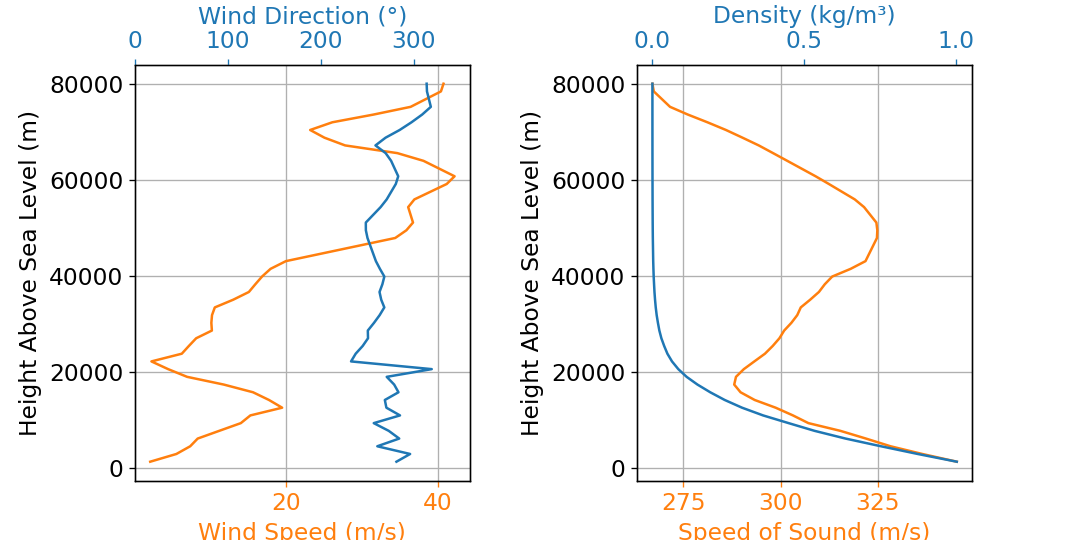

In [18]:
env.info()

In [19]:
def thrust_sim(P_tank_ox_psi, P_tank_eth_psi, 
               V_oxinit, V_ethinit, 
               CdA_inj_LOX, CdA_inj_ETH, 
               CdA_feed_LOX, CdA_feed_ETH, 
               Efficiency):
    
    #Tank Properties
    gamma_tanks = 1.41 #1.41=GN2, 1.67=GHe
    V_oxtank = 6.926 #L
    V_ethtank = 7.57 #L
    
    #Fluid Properties (SI units)
    rho_LOX = 1140.0
    rho_ETH = 798.0
    
    #Ullage
    V_oxgas = V_oxtank - V_oxinit
    V_ethgas = V_ethtank - V_ethinit
    
    #Convert initial pressures to kPa
    P_oxtank = P_tank_ox_psi * 6895
    P_ethtank = P_tank_eth_psi * 6895
    
    #Hydraulic Resistance Terms
    R_ox_inj = 1/(2*(CdA_inj_LOX**2)) #dP=Rhyd*mdot^2/rho
    R_eth_inj = 1/(2*(CdA_inj_ETH**2)) #dP=Rhyd*mdot^2/rho

    R_ox_feed = 1/(2*(CdA_feed_LOX**2)) #dP=Rhyd*mdot^2/rho
    R_eth_feed = 1/(2*(CdA_feed_ETH**2)) #dP=Rhyd*mdot^2/rho

    R_ox = R_ox_inj + R_ox_feed #Equivalent Hydraulic System Resistance
    R_eth = R_eth_inj + R_ox_feed #Equivalent Hydraulic System Resistance

    #define cstar efficiency: completeion of energy release. See RPE Pg64
#     Efficiency = 0.91 -- given as an input
    chamber = CEA_Obj(propName="", oxName="LOX", fuelName="C2H5OH") #initializs CEA object

    #define Throat Diameter, Area
    Dt = 27.54/1000 #m
    At = (Dt**2)/4*math.pi
    
    def Calculate_Residual(Pc, P_oxtank, P_ethtank):
        #solve mass flow from fluid resistances
        mdot_ox = ((1/R_ox)*rho_LOX*(P_oxtank - (Pc*6895)))**(1/2)
        mdot_eth = ((1/R_eth)*rho_ETH*(P_ethtank - (Pc*6895)))**(1/2)
        mdot_fluid = mdot_ox + mdot_eth
        #get OF rati
        OF_ratio = mdot_ox/mdot_eth
        #solve mass flow from CEA
        Cstar_fps = chamber.get_Cstar(Pc = Pc[0], MR = OF_ratio[0]) #see RPE pg64
        Cstar = float(Cstar_fps*0.3048) #m/s
        if Cstar == 0:
            print("CSTAR ZERO")
            print(f"PC = {Pc[0]}")
            mdot_CEA_res = Pc*6895*At/(abs(Cstar)*Efficiency)
        else:
            mdot_CEA_res = (Pc*6895)*At/(Cstar*Efficiency) #kg/s

        #compare residual, append to array
        error = (mdot_CEA_res-mdot_fluid)/mdot_CEA_res

        global OF_ratio_glob
        OF_ratio_glob = float(OF_ratio[0])

        global mdot_total_glob
        mdot_total_glob = float(mdot_fluid[0])

        if OF_ratio > 2.5: #tank pressure drop eqs breaking
            error = 500
        return abs(error)

    def GradientDescent(guess, P_oxtank, P_ethtank):
        # Use scipy optimize minimize with residual function to find Chamber Pressure
        result = minimize(
            Calculate_Residual,
            guess,
            args = (P_oxtank, P_ethtank),
            bounds = [(100, min([P_oxtank/6895, P_ethtank/6895]))],
        )
        P_chamber = result.x[0]
        # t = type(P_chamber)
        #print(f"Pchamb TYPE {t}")
        OF = OF_ratio_glob
        isp = chamber.estimate_Ambient_Isp(Pc=P_chamber,MR=OF,eps=4.35)[0]
        thrust = 9.8*isp*(mdot_total_glob)/1000 #kN
        print(f"Thrust {thrust}")
        massflow_total = mdot_total_glob
        print(f"massflow {massflow_total}")
        #print(f"PC {P_chamber/6895} and MR {OF_ratio} at {i*dt}")

        return P_chamber, thrust, OF, massflow_total
    
    # Initialize Array
    Residual = []

    #create Chamber Pressure Guess Array
    Pc_test_psi = np.linspace(100.0, (max(P_tank_ox_psi, P_tank_eth_psi)-1), 100) #psia
    Pc_test = Pc_test_psi*6895 #Pa

    #solve residual for each pressure guess
    for i in range(len(Pc_test)):
        #solve mass flow from fluid resistances
        mdot_ox = ((1/R_ox)*rho_LOX*(P_oxtank - Pc_test[i]))**(1/2)
        mdot_eth = ((1/R_eth)*rho_ETH*(P_ethtank - Pc_test[i]))**(1/2)
        mdot_fluid = mdot_ox + mdot_eth
        #get OF ratio
        OF_ratio_test = mdot_ox/mdot_eth

        #solve mass flow from CEA
        Cstar_fps = chamber.get_Cstar(Pc=Pc_test_psi[i], MR=OF_ratio_test) #see RPE pg64
        Cstar = Cstar_fps*0.3048 #m
        mdot_CEA = Pc_test[i]*At/(Cstar*Efficiency) #kg/s

        #compare residual, append to array
        error = (mdot_CEA-mdot_fluid)/mdot_CEA
        Residual.append(abs(error))

        plt.plot(Pc_test_psi[:i+1], Residual[:i+1])
        plt.xlabel('Chamber Pressure Guess (psia)')
        plt.ylabel('Residual Error (abs(Ratio/1))')
        plt.title('Chamber Pressure - Residual Solution Space')
        plt.grid(True)

    # Display the final plot after the loop
    plt.show()
    
    #reference thrust curve
    iterations = 250
    time = np.linspace(0, 20, iterations) #200 pts from 0 to 15 seconds
    dt = float(time[1]-time[0])
    print(f"TIMESTEP {dt}")
    OF_array = []
    Thrust_array = []
    P_chamber_array = []
    mdtot_array = []
    fin = 0
    for i in range(len(time)): #perform this for every timestep in the profile

        if i == 0:
            Pc_guess = 375
        else:
            Pc_guess = P_chamber_last-5

        P_chamber, Thrust, OF, md_tot = GradientDescent(Pc_guess, P_oxtank, P_ethtank)
        md_ox = md_tot/(
            1+1/OF)
        md_eth = md_tot-md_ox

        #print(f"Timestep {dt}")
        masslost_ox = md_ox*dt
        masslost_eth = md_eth*dt
        #print(f"masslostox {masslost_ox}")

        #print(f"Voxgas(L) {V_oxgas}")
        V_oxgas_next = V_oxgas + (masslost_ox/(rho_LOX*0.001))
        V_ethgas_next = V_ethgas + (masslost_eth/(rho_ETH*0.001))
        #print(f"Voxgasnext(L) {V_oxgas_next}")

        P_oxtank = P_oxtank*((V_oxgas/V_oxgas_next)**gamma_tanks)
        P_ethtank = P_ethtank*((V_ethgas/V_ethgas_next)**gamma_tanks)
        # print(f"Oxtank = {P_oxtank/6895}[psi] ... Ethtank = {P_ethtank/6895}[psi] at {i*dt}")

        V_oxgas = V_oxgas_next
        V_ethgas = V_oxgas_next

        mdtot_array.append(md_tot)
        OF_array.append(OF)
        Thrust_array.append(Thrust)
        P_chamber_array.append(P_chamber)
        assert len(Thrust_array) == len(P_chamber_array)
        P_chamber_last = P_chamber

        if P_chamber>(0.90*P_oxtank/6895) or P_chamber>(0.90*P_oxtank/6895):
            OxDrop = (P_oxtank/6895)/P_chamber
            ETHDrop = (P_ethtank/6895)/P_chamber
            print(f"Flow Stability Violated with {OxDrop}% LOXratio and {ETHDrop}% ETHratio")
            break

        if V_oxgas>=(V_oxtank-V_oxtank/500) or V_ethgas>=(V_ethtank-V_ethtank/500):
            oxrem = V_oxtank-V_oxgas
            ethrem = V_ethtank-V_ethgas
            print(f"Burn finished with {oxrem}L LOX and {ethrem}L ETH at Time {i*dt}s")
            break
    
    return Thrust_array, P_chamber_array, mdtot_array, OF_array

In [20]:
def write_to_eng(time, Thrust_array, filename = "/home/jovyan/Flight sim/data/motors/LE2.eng"):
    if not os.path.exists(filename):
        f = open(filename, "x")
        f.close()

    # Open the file for writing
    with open(filename, "w") as f:
        f.write("; ALULA - LE2 \n")
        f.write("; 8/1/2023 ver. \n")
        f.write("; created by UCB STAR \n")
        f.write("LE2 98 732 0 6.325 8.98822 ALULA\n")

        for i in range(len(Thrust_array)):
            f.write(f"{str(time[i])} {str(Thrust_array[i] * 1000)}\n")  # Thrust_array values in N
            
def display_plots(time, Thrust_array, P_chamber_array, mdtot_array, OF_array):
    fig, axs = plt.subplots(2, 2)
    sc = axs[0, 0].plot(time[0:len(Thrust_array)], Thrust_array)
    axs[0, 0].set_title("Thrust Curve")
    axs[0, 0].set_xlabel("Time(s)")
    axs[0, 0].set_ylabel("Thrust(kN)")

    axs[0, 1].plot(time[0:len(Thrust_array)], P_chamber_array)
    axs[0, 1].set_title("Chamber Pressure")
    axs[0, 1].set_xlabel("Time(s)")
    axs[0, 1].set_ylabel("Pchamber (psi)")

    axs[1, 0].plot(time[0:len(Thrust_array)], mdtot_array)
    axs[1, 0].set_title("Total Mass Flow")
    axs[1, 0].set_xlabel("Time(s)")
    axs[1, 0].set_ylabel("Mass Flow (kg/s)")

    axs[1, 1].plot(time[0:len(Thrust_array)], OF_array)
    axs[1, 1].set_title("OF Ratio")
    axs[1, 1].set_xlabel("Time(s)")
    axs[1, 1].set_ylabel("OF Ratio")

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_1325/3865350814.py:104: RuntimeWarning: invalid value encountered in double_scalars
  mdot_eth = ((1/R_eth)*rho_ETH*(P_ethtank - Pc_test[i]))**(1/2)


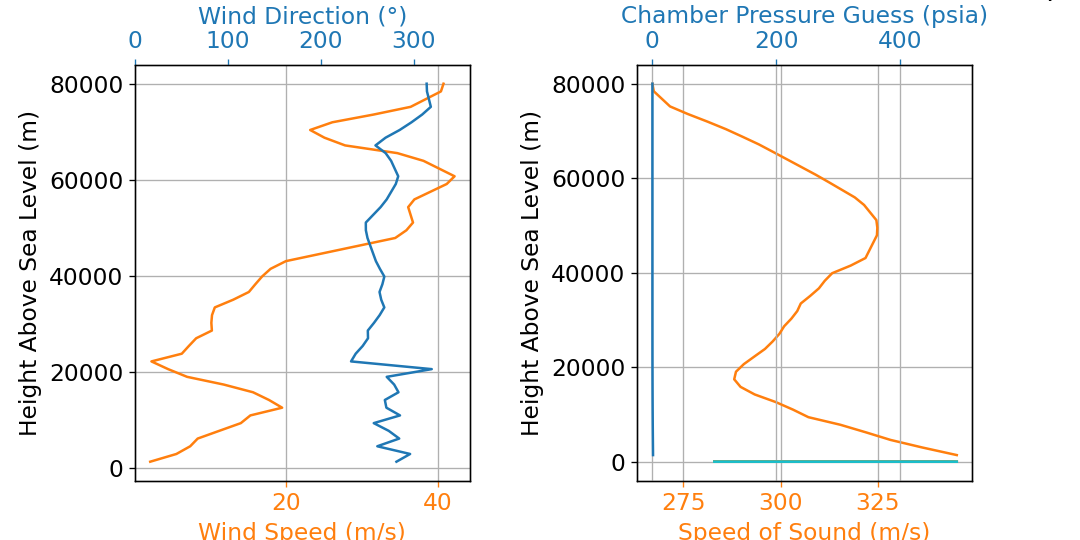

/tmp/ipykernel_1325/3865350814.py:48: RuntimeWarning: divide by zero encountered in true_divide
  OF_ratio = mdot_ox/mdot_eth
/tmp/ipykernel_1325/3865350814.py:55: RuntimeWarning: divide by zero encountered in true_divide
  mdot_CEA_res = Pc*6895*At/(abs(Cstar)*Efficiency)
/tmp/ipykernel_1325/3865350814.py:60: RuntimeWarning: invalid value encountered in true_divide
  error = (mdot_CEA_res-mdot_fluid)/mdot_CEA_res


TIMESTEP 0.08032128514056225
CSTAR ZERO
PC = 494.99999999
Thrust 2.3777290721714492
massflow 0.945810367253789
CSTAR ZERO
PC = 490.5920063279308
Thrust 2.3462602180161687
massflow 0.9336455676167517
CSTAR ZERO
PC = 483.05156562738017
Thrust 2.310434165072753
massflow 0.9207768920135955
CSTAR ZERO
PC = 475.7978879526745
CSTAR ZERO
PC = 475.7978879526745
CSTAR ZERO
PC = 475.7978879526745
Thrust 2.2759127850617826
massflow 0.908405099700297
CSTAR ZERO
PC = 468.81354250484327
CSTAR ZERO
PC = 468.81354250484327
CSTAR ZERO
PC = 468.81354250484327
Thrust 2.2426184964374567
massflow 0.8964988476615571
Thrust 2.210480223936753
massflow 0.8850295873521858
Thrust 2.179432704751565
massflow 0.8739711448534045
Thrust 2.1494158331453446
massflow 0.863299453617482
Thrust 2.1203741870711816
massflow 0.8529924296934883
Thrust 2.092256527596024
massflow 0.8430297082437888
Thrust 2.065015318539561
massflow 0.8333924439635939
Thrust 2.0386065770769988
massflow 0.8240632809470849
Thrust 2.0129892811884122


/tmp/ipykernel_1325/3865350814.py:44: RuntimeWarning: invalid value encountered in sqrt
  mdot_ox = ((1/R_ox)*rho_LOX*(P_oxtank - (Pc*6895)))**(1/2)


Thrust 1.5102642066892875
massflow 0.6394324064882175
Thrust 1.4974894157237326
massflow 0.6349947993700568
Thrust 1.484958911125503
massflow 0.6306422766063235
Thrust 1.472665184323856
massflow 0.626372144173355
Thrust 1.4606010356948664
massflow 0.6221818259966427
Thrust 1.4487594713661003
massflow 0.6180688581520215
Thrust 1.4371340339752858
massflow 0.6140308810683055
Thrust 1.4257182689467276
massflow 0.6100656359442975
Thrust 1.4145060568961019
massflow 0.6061709585981181
Thrust 1.4034916023667392
massflow 0.6023447728502563
Thrust 1.3926691504314053
massflow 0.5985850909364269
Thrust 1.382033455164486
massflow 0.5948899995826904
Thrust 1.3715791640430783
massflow 0.5912576687078769
Thrust 1.3613013219368646
massflow 0.5876863361107246
Thrust 1.351195151062271
massflow 0.5841743079681887
Thrust 1.3412560486762555
massflow 0.5807199554234745
Thrust 1.3314794903153193
massflow 0.5773217157674244
Thrust 1.32186111023389
massflow 0.5739780863918005
Thrust 1.3123968715025423
massflow 

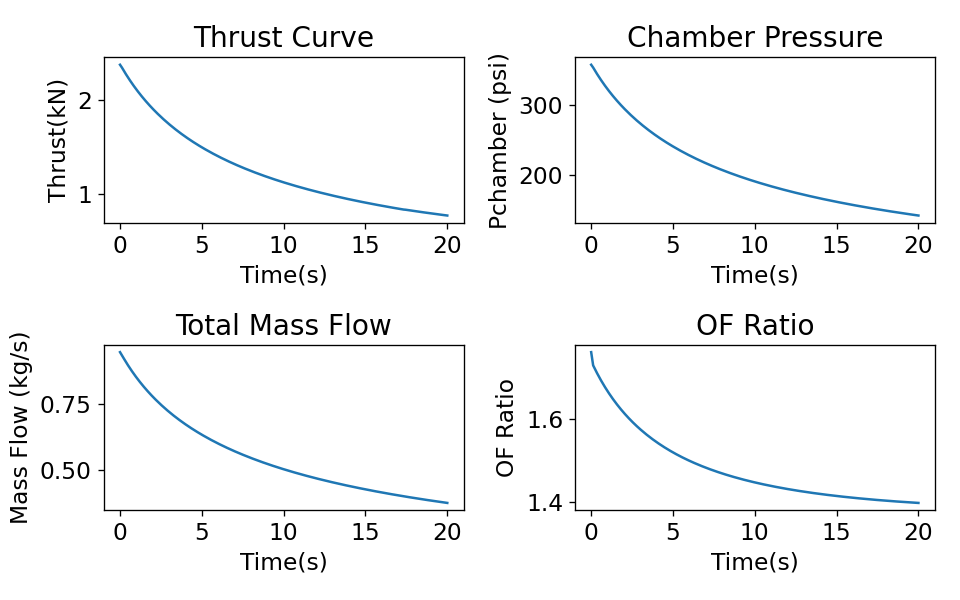

In [21]:
# Execute the functions

#thrust data + time array
Thrust, P_chamber, mdot_total, OF_ratio = thrust_sim(P_tank_ox_psi = 505.0, P_tank_eth_psi = 495.0, 
                                                     V_oxinit = 3.85, V_ethinit = 2.15, 
                                                     CdA_inj_LOX = 0.00001323, CdA_inj_ETH = 0.000009061, 
                                                     CdA_feed_LOX = 0.000040, CdA_feed_ETH = 0.00004046,
                                                     Efficiency = 0.91)
time = np.linspace(0, 20, len(Thrust))

#writing to eng file
write_to_eng(time, Thrust)

#plotting
display_plots(time, Thrust, P_chamber, mdot_total, OF_ratio)

In [22]:
from rocketpy import LiquidMotor

#change these so they're not redeclared here later (wrap this stuff in a func)
V_oxinit = 3.85 #L OPTMIMIZE THIS
V_ethinit = 2.15 #L OPTIMIZE THIS
#Fluid Properties (SI units)
rho_LOX = 1140.0
rho_ETH = 798.0


Propmass = V_oxinit/1000*rho_LOX+V_ethinit/1000*rho_ETH
print(Propmass)
LiquidMotor.propellant_initial_mass = V_oxinit/1000*rho_LOX+V_ethinit/1000*rho_ETH

LE2 = LiquidMotor(    
            thrust_source = "/home/jovyan/Flight sim/data/motors/LE2.eng",
            dry_mass=12.685,
            center_of_dry_mass=1.107,
            dry_inertia=(7.332,7.333,0.0318,-0.00153,0.0219,0.0284),
            nozzle_radius=0.0515/2,
           # burn_time,
            nozzle_position=0,
            reshape_thrust_curve=False,
            interpolation_method="linear",
            coordinate_system_orientation="nozzle_to_combustion_chamber",
)

6.1047


Nozzle Details
Nozzle Radius: 0.02575 m

Motor Details
Total Burning Time: 20.0 s
Total Propellant Mass: 6.105 kg
Average Propellant Exhaust Velocity: nan m/s
Average Thrust: 1236.825 N
Maximum Thrust: 2346.260218016169 N at 0.12121212121212122 s after ignition.
Total Impulse: 24736.491 Ns



/home/jovyan/Flight sim/rocketpy/Function.py:2178: RuntimeWarning: divide by zero encountered in double_scalars
  return Function(lambda x: (self.get_value_opt(x) / other(x)))
/home/jovyan/Flight sim/rocketpy/Function.py:2487: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  ans, _ = integrate.quad(self, a, b, epsabs=0.001, limit=10000)


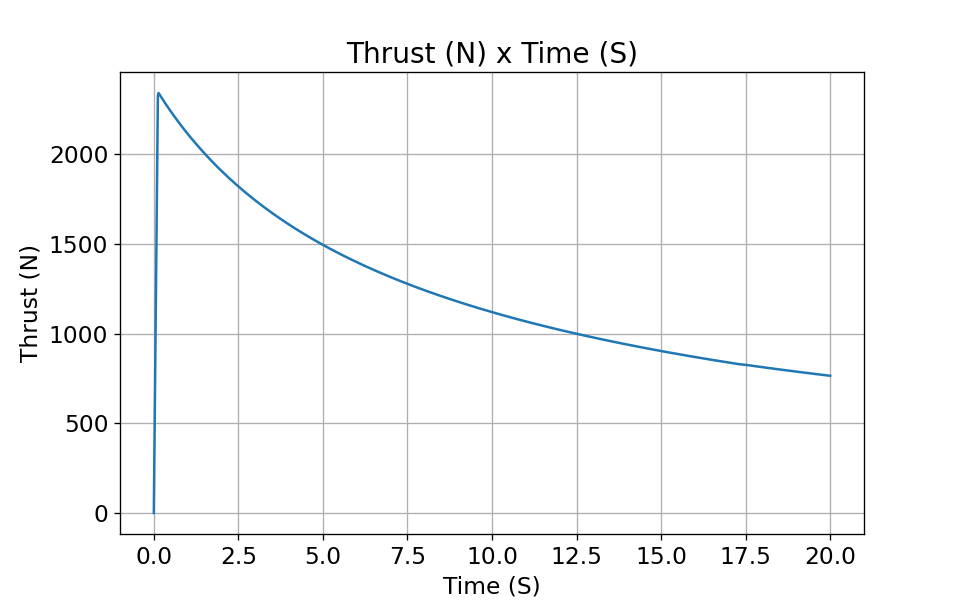

In [23]:
LE2.info()

In [24]:
ALULA = Rocket(
        #self,
        radius=0.0785,
        mass=36.338, #*0.9,     #  total dry
        inertia=(40.32089762,40.32707615,0.16968255,-0.00501791,-0.33114339,0.44168709),
        power_off_drag = "../RocketPy-100a1/docs/notebooks/dispersion_analysis/dispersion_analysis_inputs/LE2_Inserts_Drag_-_Sheet1.csv", ##UPDATE
        power_on_drag = "../RocketPy-100a1/docs/notebooks/dispersion_analysis/dispersion_analysis_inputs/LE2_Inserts_Drag_-_Sheet1.csv", ##UPDATE
        center_of_mass_without_motor=1.996, 
        coordinate_system_orientation = "tail_to_nose",
)

railButtons = ALULA.set_rail_buttons(
    upper_button_position=0.18,
    lower_button_position=-1.4246,
    angular_position=60,
)

ALULA.add_motor(LE2, position=0) # origin = nozzle outlet

NoseCone = ALULA.add_nose(length=0.762, kind="vonKarman", position=3.99) 

FinSet = ALULA.add_trapezoidal_fins(
    n=3,
    root_chord =0.305,
    tip_chord=0.102,
    span=0.152,
    position=0.4,
    sweep_angle=33.7
)

FileNotFoundError: [Errno 2] No such file or directory: '../RocketPy-100a1/docs/notebooks/dispersion_analysis/dispersion_analysis_inputs/LE2_Inserts_Drag_-_Sheet1.csv'

In [ ]:
ALULA.info()

In [ ]:
#ALULA.parachutes.remove(drogue)
#ALULA.parachutes.remove(main)

In [ ]:
main = ALULA.add_parachute(
    name="main", #84"d - 120"d
    cd_s=3.464577329*2.2, #^7.07050353*2.2,
    trigger=457.2,  # ejection altitude: 1000ft
    sampling_rate=105,
    lag=0, #1.5
    noise=(0, 8.3, 0.5),
)

drogue = ALULA.add_parachute(
    name="drogue", #60''d
    cd_s=1.767638271*2.2,
    trigger="apogee",  # ejection at apogee
    sampling_rate=105,
    lag=0, #1.5
    noise=(0, 8.3, 0.5),
)

## Flight Results

In [ ]:
test_flight = Flight(
  rocket=ALULA, environment=env, rail_length=18.288, inclination=85, heading=0
)

In [ ]:
test_flight.all_info()

In [ ]:
test_flight.export_kml(
    file_name="AlulaTestFlight.kml",
    extrude=True,
    altitude_mode="relativetoground",
) #Import kml file to Google Earth!

In [ ]:
# Plot & Print static margin for entire flight
test_flight.static_margin.plot(0, test_flight.t_final)
print(test_flight.static_margin(np.linspace(0, test_flight.t_final))) 